In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics


### Data Preprocessing

In [2]:
data = pd.read_csv('energy consumption.csv')
data.head()


,DATE,ENERGY_INDEX
0,01/1939,3.3842
1,02/1939,3.4100
2,03/1939,3.4875
3,04/1939,3.5133
4,05/1939,3.5133


In [3]:
data.shape


(969, 2)

In [4]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.head()


,DATE,ENERGY_INDEX
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133


In [5]:
# Calculating difference between last and first value in months
12*(data['DATE'].max().year - data['DATE'].min().year) + \
    (data['DATE'].max().month - data['DATE'].min().month)


968

No missing values!

In [6]:
data.set_index('DATE', inplace=True)


In [7]:
data.head()


,ENERGY_INDEX
DATE,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


In [8]:
data.tail()


,ENERGY_INDEX
DATE,
2019-05-01,91.9046
2019-06-01,98.4397
2019-07-01,112.9469
2019-08-01,111.6645
2019-09-01,102.2911


<AxesSubplot:xlabel='DATE'>

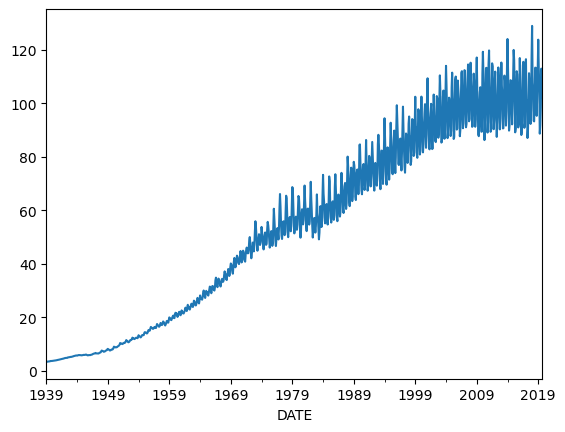

In [9]:
data['ENERGY_INDEX'].plot()


In [10]:
decom_data = seasonal_decompose(data['ENERGY_INDEX'])


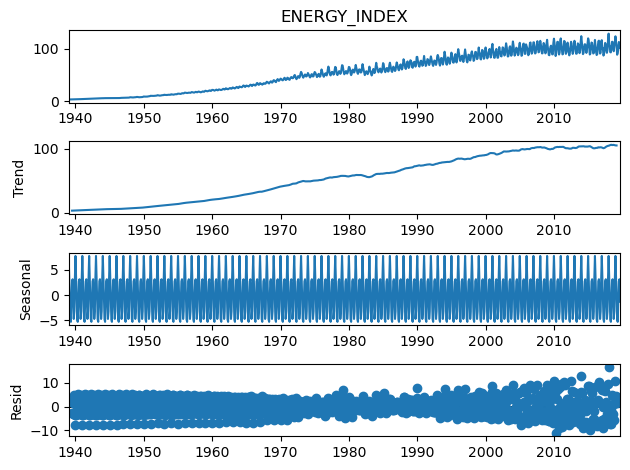

In [11]:
decom_data.plot()


<AxesSubplot:xlabel='DATE'>

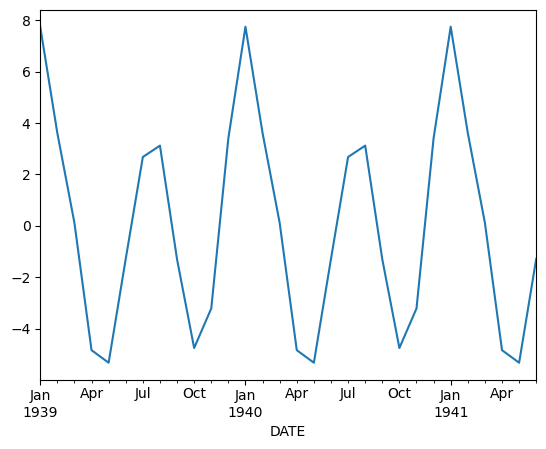

In [12]:
decom_data.seasonal[0:30].plot()


We have an yearly seasonality

### Creating training and validation sets

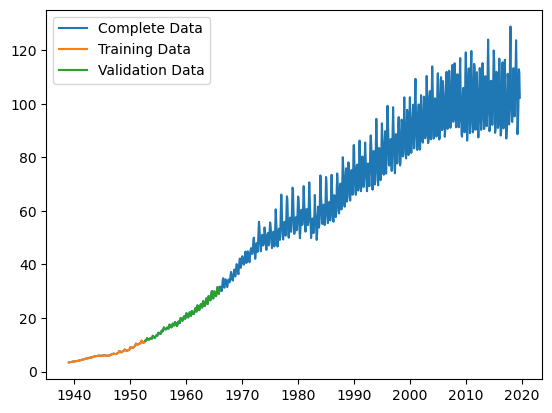

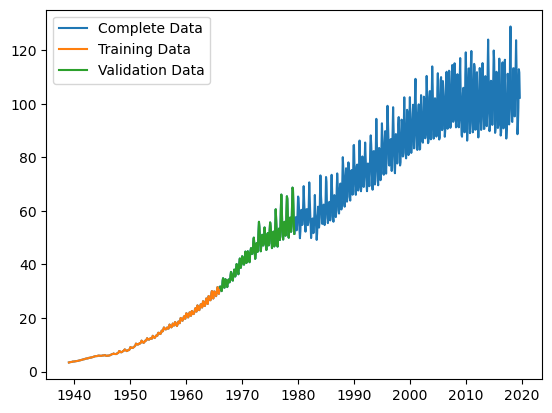

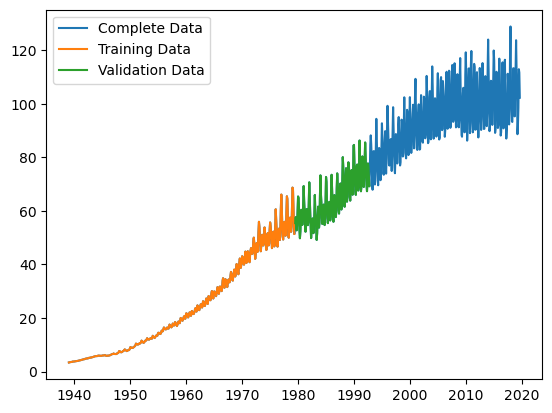

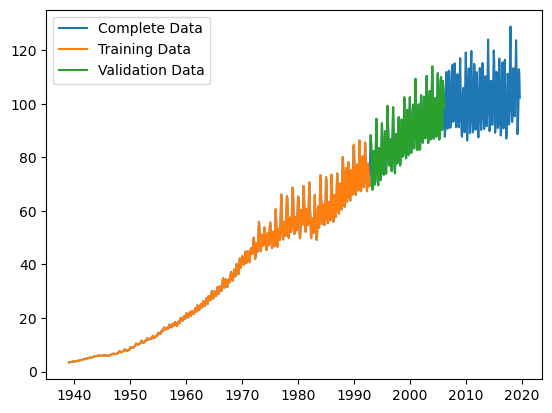

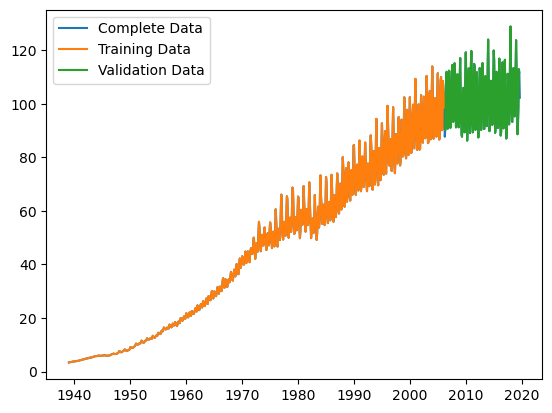

In [13]:
time_series_cv = TimeSeriesSplit(n_splits=5)
for train_index, valid_index in time_series_cv.split(data):
    plt.plot(data['ENERGY_INDEX'], label='Complete Data')
    plt.plot(data.iloc[train_index[0]:train_index[-1]]
             ['ENERGY_INDEX'], label='Training Data')
    plt.plot(data.iloc[valid_index[0]:valid_index[-1]]
             ['ENERGY_INDEX'], label='Validation Data')
    plt.legend()
    plt.show()


In [14]:
def rmse_calculator(model, transform, reverse_transform, data: pd.DataFrame, n_splits: int, **kwargs) -> float:
    '''
    Description: This function takes in a timeseries model, a reverse transform, its parameters, time series data indexed by timeseries and number of train-test splits to be created. It plots each iteration, returns the mean rmse cross validation score and the model parameters.

    Parameters:
    model: statsmodels model with parameters
    transform: data preprocessing transform function
    reverse_transform: data reverse transform function
    data (pd.DataFrame): data with timeseries index
    n_splits (int) : Number of train-test splits for cross validation
    kwargs : parameters passed to model

    Return (float) : Mean rmse across all splits
    Return : model parameters
    '''
    time_series_cv = TimeSeriesSplit(n_splits=n_splits)
    rmse_list = []

    fig, axs = plt.subplots(((n_splits-1)//3+1), 3, sharex='col', sharey='row')
    i = 0
    for train_index, valid_index in time_series_cv.split(data):
        train_data = data.iloc[train_index[0]:train_index[-1]]
        train_data_transformed = transform(train_data)
        valid_data = data.iloc[valid_index[0]:valid_index[-1]]

        model_ = model(np.asarray(train_data_transformed), **kwargs)
        model_fit = model_.fit()
        pred = model_fit.forecast(valid_data.shape[0])
        pred_data = pd.DataFrame(pred, index=valid_data.index)
        pred_data_transformed = reverse_transform(pred_data)

        rmse = sqrt(mse(valid_data.values, pred_data_transformed.values))
        rmse_list.append(rmse)

        ax = axs[i//3, i % 3]
        l1 = ax.plot(data, label='Complete Data')
        l2 = ax.plot(train_data, label='Training Data')
        l3 = ax.plot(valid_data, label='Validation Data')
        l4 = ax.plot(pred_data_transformed, label='Prediction Data')

        locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)

        i = i+1

    #lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines_labels = [fig.axes[0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    plt.legend(lines, labels)
    plt.show()

    return np.mean(rmse_list), model_fit.params


In [15]:
RMSE = {}


### Triple Exponential Smoothing

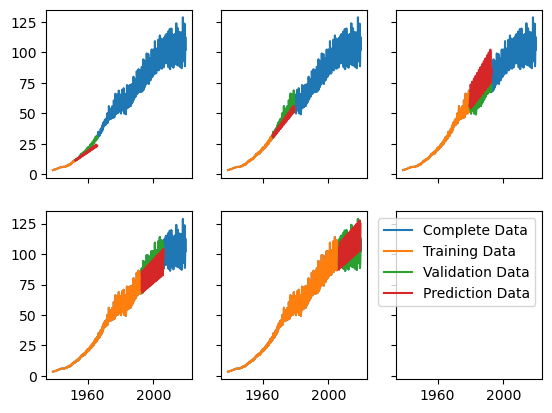

7.909546794075832

In [16]:
def transform(data):
    return data


def reverse_transform(data):
    return data


holt_rmse, holt_params = rmse_calculator(model=ExponentialSmoothing, transform=transform, reverse_transform=reverse_transform, data=data['ENERGY_INDEX'], n_splits=5,
                                         seasonal_periods=12, trend='add', seasonal='mul')
RMSE['holt'] = holt_rmse
RMSE['holt']


In [17]:
holt_params


{'smoothing_level': 0.3597252627019745,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': 0.35544452631332096,
 'damping_trend': nan,
 'initial_level': 2.974583703388967,
 'initial_trend': 0.1186804412935393,
 'initial_seasons': array([1.07299789, 1.06730474, 1.06921952, 1.07033029, 1.07126807,
        1.0823411 , 1.08568065, 1.08929399, 1.09476511, 1.0883387 ,
        1.08882883, 1.07820355]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### ARIMA

In [18]:
def adf_test_pvalue(data):
    test = adfuller(data, autolag='AIC', )
    return test[1]


In [19]:
adf_test_pvalue(data['ENERGY_INDEX'])


0.9171521821410459

Not Stationary

In [20]:
data['ENERGY_INDEX_D1'] = data['ENERGY_INDEX'] - data['ENERGY_INDEX'].shift(1)


In [21]:
adf_test_pvalue(data['ENERGY_INDEX_D1'].dropna())


1.6833827658844682e-17

Stationary after one differencing

<AxesSubplot:xlabel='DATE'>

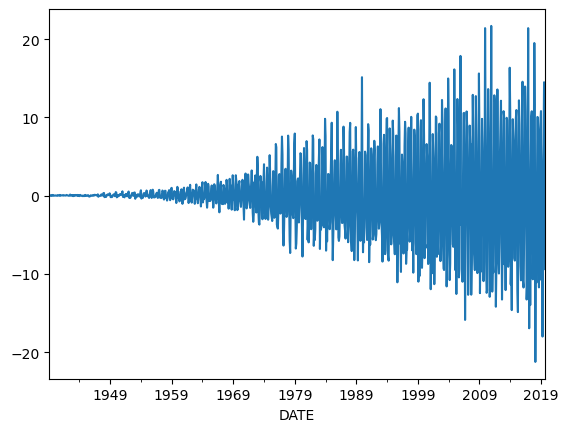

In [22]:
data['ENERGY_INDEX_D1'].dropna().plot()


Variance is still increasing. Taking log transform.

In [23]:
data['log_ENERGY_INDEX'] = np.log(data['ENERGY_INDEX'])
data['log_ENERGY_INDEX_D1'] = data['log_ENERGY_INDEX'] - \
    data['log_ENERGY_INDEX'].shift(1)


In [24]:
adf_test_pvalue(data['log_ENERGY_INDEX_D1'].dropna())


2.911925318561303e-06

<AxesSubplot:xlabel='DATE'>

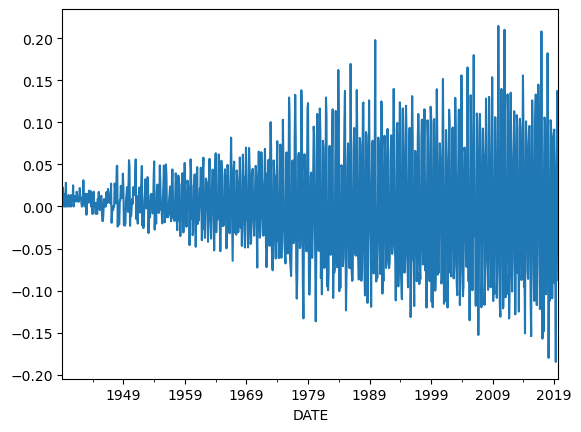

In [25]:
data['log_ENERGY_INDEX_D1'].dropna().plot()


##### ACF and PACF Plot

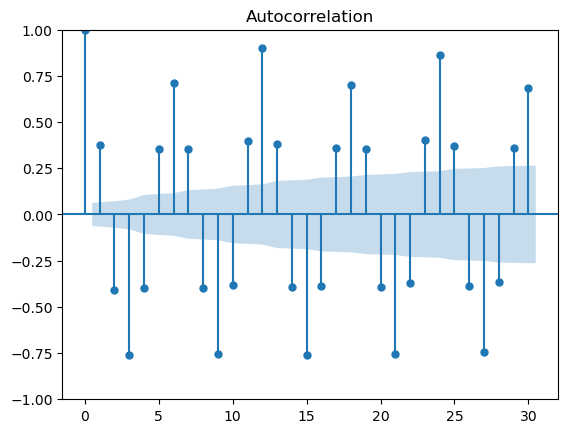

In [26]:
plot_acf(data['log_ENERGY_INDEX_D1'].dropna())


/home/laksie98/opt/anaconda3/envs/av-prophet/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


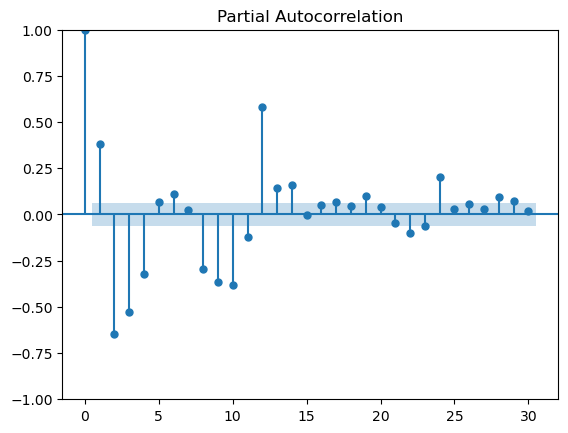

In [27]:
plot_pacf(data['log_ENERGY_INDEX_D1'].dropna())


Since PACF drops off after lag 4, we use AR(4) as our model

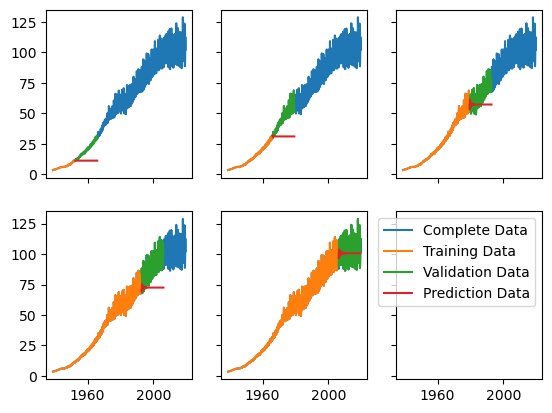

13.62462305090197

In [28]:
def transform(data):
    return np.log(data)


def reverse_transform(data):
    return np.exp(data)


ARIMA_rmse, ARIMA_params = rmse_calculator(model=ARIMA, transform=transform, reverse_transform=reverse_transform, data=data['ENERGY_INDEX'], n_splits=5,
                                           order=(4, 1, 0))
RMSE['arima'] = ARIMA_rmse
RMSE['arima']


In [29]:
ARIMA_params


array([ 0.25337841, -0.42863452, -0.37982497, -0.21550284,  0.00120648])

### SARIMA

In [30]:
adf_test_pvalue(data['ENERGY_INDEX'])


0.9171521821410459

Not Stationary

In [31]:
data['ENERGY_INDEX_SD1'] = data['ENERGY_INDEX'] - \
    data['ENERGY_INDEX'].shift(12)


In [32]:
adf_test_pvalue(data['ENERGY_INDEX_SD1'].dropna())


1.40004734718173e-08

Stationary after one seasonal differencing

<AxesSubplot:xlabel='DATE'>

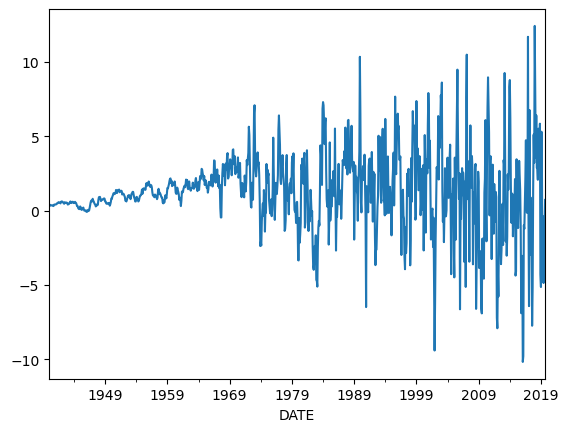

In [33]:
data['ENERGY_INDEX_SD1'].dropna().plot()


Variance is still increasing. Taking log transform.

In [34]:
data['log_ENERGY_INDEX'] = np.log(data['ENERGY_INDEX'])
data['log_ENERGY_INDEX_SD1'] = data['log_ENERGY_INDEX'] - \
    data['log_ENERGY_INDEX'].shift(12)


In [35]:
adf_test_pvalue(data['log_ENERGY_INDEX_SD1'].dropna())


0.010224413621692066

<AxesSubplot:xlabel='DATE'>

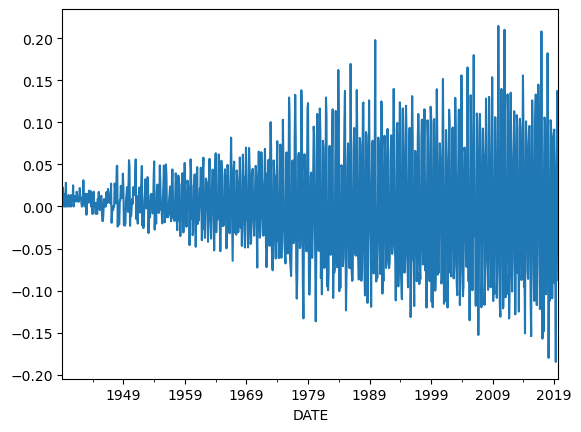

In [36]:
data['log_ENERGY_INDEX_D1'].dropna().plot()


##### ACF and PACF Plot

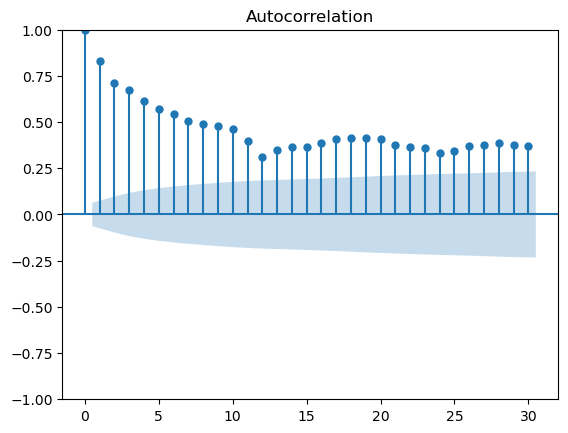

In [37]:
plot_acf(data['log_ENERGY_INDEX_SD1'].dropna())


/home/laksie98/opt/anaconda3/envs/av-prophet/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


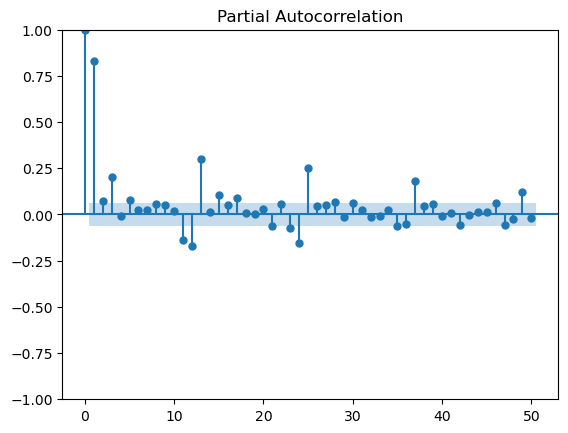

In [38]:
plot_pacf(data['log_ENERGY_INDEX_SD1'].dropna(), lags=50)


Since PACF drops off after lag 24 to 36, we use AR(2) in our seasonal order

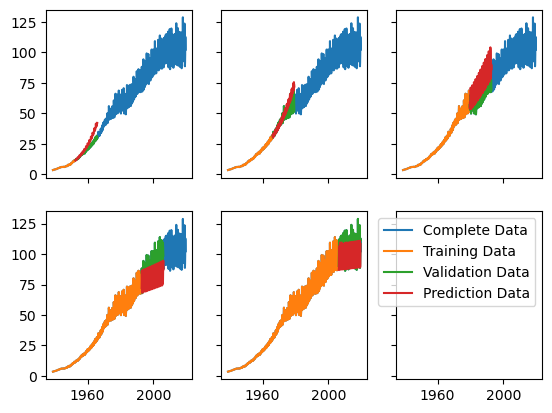

9.139299027148752

In [44]:
def transform(data):
    return np.log(data)


def reverse_transform(data):
    return np.exp(data)


SARIMA_rmse, SARIMA_params = rmse_calculator(model=ARIMA, transform=transform, reverse_transform=reverse_transform, data=data['ENERGY_INDEX'], n_splits=5,
                                             order=(4, 1, 0), seasonal_order=(2, 1, 0, 12))
RMSE['sarima'] = SARIMA_rmse
RMSE['sarima']


In [45]:
SARIMA_params


array([-1.20088191e-01, -2.43605103e-01, -8.87527400e-02, -1.23368392e-01,
       -5.40409429e-01, -3.26496154e-01,  3.99138099e-04])

### Prophet

In [54]:
prophet_data = pd.DataFrame()
prophet_data['ds'] = data.index
prophet_data['y'] = data['ENERGY_INDEX'].values
prophet_data

,ds,y
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133
...,...,...
964,2019-05-01,91.9046
965,2019-06-01,98.4397
966,2019-07-01,112.9469
967,2019-08-01,111.6645


In [85]:
time_series_cv = TimeSeriesSplit(n_splits=5)
cutoffs = []
for train_index, valid_index in time_series_cv.split(data):
    cutoffs.append(prophet_data.iloc[train_index[-1]]['ds'])
cutoffs

[Timestamp('1952-08-01 00:00:00'),
 Timestamp('1966-01-01 00:00:00'),
 Timestamp('1979-06-01 00:00:00'),
 Timestamp('1992-11-01 00:00:00'),
 Timestamp('2006-04-01 00:00:00')]

In [87]:
horizon = cutoffs[1]-cutoffs[0]
horizon

Timedelta('4901 days 00:00:00')

In [88]:
model = Prophet()
model_fit = model.fit(prophet_data)
df_cv = cross_validation(model_fit, cutoffs=cutoffs, horizon = '4901 days')


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.60375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2813.21      0.013224       615.631      0.8573      0.8573      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2824.58    0.00266043       273.179           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2826.22    0.00393455       144.372           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     337       2827.87   0.000104528       116.856   3.416e-07       0.001      433  LS failed, Hessian reset 
     393       2829.19   0.000182735       146.456   2.257e-06       0.001      529  LS failed, Hessian reset 
     399       2829.26   0.000612361       107.229      0.5255      0.5255      536   
    Iter      log pro

  0%|          | 0/5 [00:00<?, ?it/s]

Initial log joint probability = -2.59477
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       586.797    0.00262236       162.714      0.9213      0.9213      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       593.178   0.000220885       241.277      0.4343      0.4343      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       594.108   0.000107856       139.012   5.111e-07       0.001      314  LS failed, Hessian reset 
     299       594.653     0.0020242       106.368           1           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       595.408    8.5777e-05       126.822   6.493e-07       0.001      486  LS failed, Hessian reset 
     364       595.872   0.000103275       133.657   1.084e-06       0.001      573  LS failed, Hessian rese

 20%|██        | 1/5 [00:01<00:05,  1.44s/it]

Initial log joint probability = -5.59425
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1231.15    0.00318359       442.983           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1239.77    0.00433917       390.845      0.4306      0.4306      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       1241.55   5.09197e-05       120.392   4.685e-07       0.001      342  LS failed, Hessian reset 
     299       1242.74    0.00131359       175.592      0.6815      0.6815      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       1242.92   0.000114305       329.871   2.213e-07       0.001      448  LS failed, Hessian reset 
     387       1244.47   0.000104362       230.029   1.053e-06       0.001      604  LS failed, Hessian rese

 40%|████      | 2/5 [00:02<00:04,  1.42s/it]

Initial log joint probability = -4.21581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1532.99    0.00425927       630.324      0.6941      0.6941      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1537.27    0.00192434       100.529           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1540.09   0.000493066       100.599           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     358       1540.13   2.50408e-05       53.5079    3.66e-07       0.001      507  LS failed, Hessian reset 
     390       1540.13   1.40799e-07        46.078           1           1      552   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 60%|██████    | 3/5 [00:04<00:02,  1.43s/it]

Initial log joint probability = -4.13595
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1895.11     0.0136957       252.087           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1901.43    0.00813064       323.301      0.2835      0.9503      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       1902.92   9.09722e-05       103.336   1.136e-06       0.001      322  LS failed, Hessian reset 
     299       1903.71   0.000544804        74.251      0.6517      0.6517      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394       1904.24   3.96423e-05        51.988   5.512e-07       0.001      560  LS failed, Hessian reset 
     399       1904.24   8.88323e-05       53.4557           1           1      565   
    Iter      log pro

 80%|████████  | 4/5 [00:05<00:01,  1.42s/it]

Initial log joint probability = -4.05114
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2424.05    0.00068304       124.733      0.9521      0.9521      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       2429.65   8.09139e-05       128.053   7.279e-07       0.001      219  LS failed, Hessian reset 
     184       2431.81   9.94259e-05       118.733   3.646e-07       0.001      297  LS failed, Hessian reset 
     199       2432.29    0.00548104       302.035           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       2434.39   0.000199425        268.49   4.429e-07       0.001      436  LS failed, Hessian reset 
     299       2434.79   4.13993e-05       95.7495       0.431       0.431      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


In [90]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1952-09-01,11.570616,11.364170,11.764631,11.5475,1952-08-01
1,1952-10-01,11.636667,11.452007,11.828586,11.5217,1952-08-01
2,1952-11-01,11.777516,11.593362,11.973445,11.6250,1952-08-01
3,1952-12-01,11.967792,11.773168,12.179509,12.0384,1952-08-01
4,1953-01-01,12.123135,11.936963,12.334218,12.4517,1952-08-01


In [92]:
df_p = performance_metrics(df_cv)

In [95]:
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,488 days,18.441304,4.294334,3.067438,0.046213,0.036346,0.375000
1,516 days,17.868543,4.227120,2.987721,0.045295,0.035721,0.387500
2,518 days,17.421395,4.173894,2.920172,0.044371,0.034592,0.406250
3,519 days,17.638800,4.199857,2.967662,0.045134,0.035721,0.400000
4,546 days,17.848439,4.224741,3.011210,0.045888,0.036346,0.381250
...,...,...,...,...,...,...,...
391,4868 days,117.882826,10.857386,8.247826,0.112565,0.107393,0.345000
392,4870 days,116.496654,10.793362,8.224125,0.112137,0.108060,0.340000
393,4871 days,116.382689,10.788081,8.254778,0.112591,0.108060,0.337500
394,4899 days,111.216806,10.545938,8.069013,0.110785,0.108060,0.341667


In [96]:
RMSE['prophet'] = np.mean(df_p['rmse'].values)

In [97]:
RMSE

{'holt': 7.909546794075832,
 'arima': 13.62462305090197,
 'sarima': 9.139299027148752,
 'prophet': 7.765340721319255}

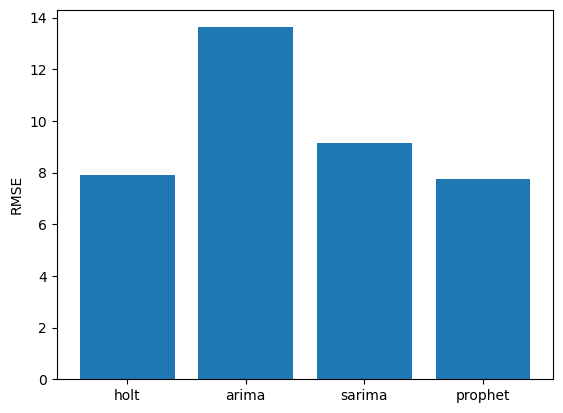

In [104]:
names = list(RMSE.keys())
values = list(RMSE.values())

plt.bar(range(len(RMSE)), values, tick_label=names)
plt.ylabel('RMSE')
plt.show()

Prophet performs the best followed by Holt Winters